<a href="https://colab.research.google.com/github/Maskify/maskify.github.io/blob/master/Supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
###import commands
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import json
from pylab import *
from matplotlib.pyplot import *
import imageio

**Installing Darknet**

In [ ]:
!git clone https://github.com/Maskify/darknet

fatal: destination path 'darknet' already exists and is not an empty directory.


**Updating Make File**

In [ ]:
%cd darknet
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!cat Makefile
!make 

/content/darknet
GPU=1
CUDNN=0
CUDNN_HALF=0
OPENCV=1
AVX=0
OPENMP=0
LIBSO=0
ZED_CAMERA=0
ZED_CAMERA_v2_8=0

# set GPU=1 and CUDNN=1 to speedup on GPU
# set CUDNN_HALF=1 to further speedup 3 x times (Mixed-precision on Tensor Cores) GPU: Volta, Xavier, Turing and higher
# set AVX=1 and OPENMP=1 to speedup on CPU (if error occurs then set AVX=0)
# set ZED_CAMERA=1 to enable ZED SDK 3.0 and above
# set ZED_CAMERA_v2_8=1 to enable ZED SDK 2.X

USE_CPP=0
DEBUG=0

ARCH= -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52] \
	    -gencode arch=compute_61,code=[sm_61,compute_61]

OS := $(shell uname)

# GeForce RTX 3070, 3080, 3090
# ARCH= -gencode arch=compute_86,code=[sm_86,compute_86]

# Kepler GeForce GTX 770, GTX 760, GT 740
# ARCH= -gencode arch=compute_30,code=sm_30

# Tesla A100 (GA100), DGX-A100, RTX 3080
# ARCH= -gencode arch=compute_80,code=[sm_80,compute_80]

# Tesla V100
# ARCH= -genco

**Downloading the temporary weights for the respective cfg file**

In [ ]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2020-12-06 21:00:50--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74.1’

darknet53.conv.74.1 100%[===================>] 154.96M  1.15MB/s    in 1m 47s  

2020-12-06 21:02:37 (1.45 MB/s) - ‘darknet53.conv.74.1’ saved [162482580/162482580]



**Updating yolov3.cfg file according to the data set**

**Mandatory:**
*   random 0 to 1 Max_batch = No_of classes * 2000 
*   filters = (classes + 5)x3 
*   subdivitions should be 8 batches to 32*



In [ ]:
!sed -i 's/batch=1/batch=32/g' cfg/yolov3.cfg
!sed -i 's/subdivisions=1/subdivisions=8/g' cfg/yolov3.cfg
!sed -i 's/random=1/random=0/g' cfg/yolov3.cfg
!sed -i 's/max_batches = 500200/max_batches = 4000/g' cfg/yolov3.cfg
!sed -i 's/steps=400000,450000/steps=3200,3600/g' cfg/yolov3.cfg
!sed -i 's/classes=80/classes=2/g' cfg/yolov3.cfg
!sed -i 's/filters=255/filters=21/g' cfg/yolov3.cfg
!cat cfg/yolov3.cfg

[net]
# Testing
batch=32
subdivisions=8
# Training
# batch=64
# subdivisions=86
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 4000
policy=steps
steps=3200,3600
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
ba

**Ensuring bounding box classes are 0 and 1**

In [ ]:
import fileinput
from PIL import Image
import os, os.path

imgs = []
path = "/content/darknet/data/final_images_and_labels_combined"
valid_text_files = [".txt"]
for f in os.listdir(path):
  ext = os.path.splitext(f)[1]
  if ext.lower() not in valid_text_files:
    continue
    
  with fileinput.FileInput(path +"/" + f, inplace=True) as file:
    for line in file:
      if line[:2] == "15":
        #people with masks
        line = "0" + line[2:] 
      elif line[:2] == "16":
        #people without masks
        line = "1" + line[2:]
      elif line[:2] == "17":
        line = "1" + line[2:]
      print(line)

**Training The Data**

Darknet is the detector where it is gonna train data with following files with weights and cfg 

In [ ]:
!./darknet detector train data/obj.data cfg/yolov3.cfg darknet53.conv.74 -dont_show >> log/training-log.log

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.582710), count: 4, total_loss = 1.860333 
 total_bbox = 163130, rewritten_bbox = 0.000613 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.748826), count: 3, total_loss = 0.288397 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.762638), count: 6, total_loss = 0.472697 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, total_loss = 0.039674 
 total_bbox = 163139, rewritten_bbox = 0.000613 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.716146), count: 3, total_loss = 0.592013 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.770297), count: 4, total_loss = 0.653897 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.665672), count: 4,

**Plotting loss chart**

In [ ]:
!python plot_yolo_log.py /content/darknet/log/training-log.log

**Copy or Download the weights**

In [ ]:
import shutil

shutil.copy("/content/darknet/backup/yolov3_last.weights","/content/weights")
#copying to gdrive
shutil.copy("/content/darknet/backup/yolov3_last.weights","/content/gdrive/MyDrive/CS\ 4641/siyu_weights")

FileNotFoundError: ignored

**Training with -mAP**

In [ ]:
!./darknet detector train data/obj.data cfg/yolov3.cfg darknet53.conv.74 -dont_show -map

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.368821), count: 20, total_loss = 426.391998 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.185549), count: 2, total_loss = 1487.493896 
 total_bbox = 9527, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.112523), count: 1, total_loss = 139.695221 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.293370), count: 4, total_loss = 416.085205 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.178758), count: 4, total_loss = 1507.233154 
 total_bbox = 9536, rewritten_bbox = 0.000000 % 

 (next mAP calculation at 1000 iterations) 
 82: 683.290100, 745.945068 avg loss, 0.000000 rate, 3.561786 seconds, 2624 images, 4.329178 hours left
Loaded: 0.000053 seconds
v3 (mse loss, Normalizer: (iou: 0.75, obj:

**Observe mAP increases with iteration 700**

You can update 700 to 1000+ to see which performance is better

In [ ]:
#run this line if /content/weights exists
!./darknet detector map data/obj.data cfg/yolov3.cfg /content/weights/yolov3_700.weights -dont_show

 CUDA-version: 10010 (10010), GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 610, cudnn_half = 0, GPU: Tesla P4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv   

In [ ]:
#run this line instead if colab refreshed and you don't see /content/weight (aka we loaded the weights onto gdrive instead)
!./darknet detector map data/obj.data cfg/yolov3.cfg /content/gdrive/MyDrive/CS\ 4641/katherine_weights/complete/yolov3_last.weights -dont_show

 CUDA-version: 10010 (10010), GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 610, cudnn_half = 0, GPU: Tesla P4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv   

**Comparing the mAP of weight file with 1300 versus 700**

In [ ]:
!./darknet detector map data/obj.data cfg/yolov3.cfg /content/weights/yolov3_1300.weights -dont_show

 CUDA-version: 10010 (10010), GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 610, cudnn_half = 0, GPU: Tesla P4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv   

In [ ]:
!./darknet detector map data/obj.data cfg/yolov3.cfg /content/gdrive/MyDrive/CS\ 4641/katherine_weights/complete/yolov3_last.weights -dont_show

 CUDA-version: 10010 (10010), GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 610, cudnn_half = 0, GPU: Tesla P4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv   

**Testing**

In [ ]:
#image without mask#
!./darknet detector test data/obj.data cfg/yolov3.cfg /content/gdrive/MyDrive/CS\ 4641/katherine_weights/complete/yolov3_last.weights /content/data_without_mask/withoutMask277.jpg -dont_show

 CUDA-version: 10010 (10010), GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 610, cudnn_half = 0, GPU: Tesla P4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv   

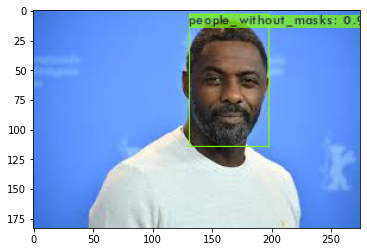

In [ ]:
def display_image(file_path = '/content/darknet/predictions.jpg'):
    import cv2
    import matplotlib.pyplot as plt
    import os.path

    if os.path.exists(file_path):
      img = cv2.imread(file_path)
      show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
      plt.imshow(show_img)
    else:
      print('failed to open file')
    
display_image()

In [ ]:
#image with mask#
!./darknet detector test data/obj.data cfg/yolov3.cfg /content/gdrive/MyDrive/CS\ 4641/katherine_weights/complete/yolov3_last.weights /content/data_with_masks/withMask418.jpeg -dont_show < data/train.txt > /content/darknet/results.txt

import shutil
shutil.copy("/content/darknet/results.txt","/content/darknet/results/results.txt")

 CUDA-version: 10010 (10010), GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 610, cudnn_half = 0, GPU: Tesla P4 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
  10 conv   

'/content/darknet/results/results.txt'

In [ ]:
#!/usr/bin/env python3
import fileinput
from PIL import Image
import os, os.path

imgs = []
path = "/content/darknet/results"
valid_text_files = [".txt"]
for f in os.listdir(path):
  ext = os.path.splitext(f)[1]
  if ext.lower() not in valid_text_files:
    continue
    
  mask_count = 0
  without_mask_count = 0
  with fileinput.FileInput(path +"/" + f, inplace=False) as file:
    for line in file:
      if line[:17] == "people_with_masks":
        mask_count += 1
      elif line[:20] == "people_without_masks":
        without_mask_count += 1


print('Number of people with masks:', mask_count)
print('Number of people without masks:', without_mask_count)

Number of people with masks: 2
Number of people without masks: 0


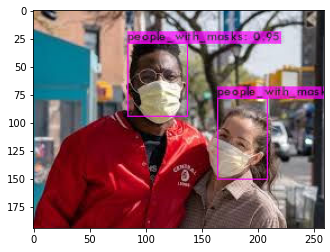

In [ ]:
def display_image(file_path = '/content/darknet/predictions.jpg'):
    import cv2
    import matplotlib.pyplot as plt
    import os.path

    if os.path.exists(file_path):
      img = cv2.imread(file_path)
      show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
      plt.imshow(show_img)
    else:
      print('failed to open file')
    
display_image()

In [ ]:
#image mixed with and without mask#
!./darknet detector test data/obj.data cfg/yolov3.cfg /content/gdrive/MyDrive/CS\ 4641/katherine_weights/complete/yolov3_last.weights /content/data_with_without_masks/mixed120.jpg -dont_show

 CUDA-version: 10010 (10010), GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 610, cudnn_half = 0, GPU: Tesla P4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv   

In [1]:
def display_image(file_path = '/content/darknet/predictions.jpg'):
    import cv2
    import matplotlib.pyplot as plt
    import os.path

    if os.path.exists(file_path):
      img = cv2.imread(file_path)
      show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
      plt.imshow(show_img)
    else:
      print('failed to open file')
    
display_image()

failed to open file
